In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [2]:
url = "https://julie-resources.s3.eu-west-3.amazonaws.com/full-stack-full-time/projects-supervised-machine-learning-ft/walmart-sales-ft/Walmart_Store_sales.csv"
df  = pd.read_csv(url)
df.head(10)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
5,4.0,28-05-2010,1857533.70,0.0,NaN,2.756,126.160226,7.896
6,15.0,03-06-2011,695396.19,0.0,69.80,4.069,134.855161,7.658
7,20.0,03-02-2012,2203523.20,0.0,39.93,3.617,213.023622,6.961
8,14.0,10-12-2010,2600519.26,0.0,30.54,3.109,NaN,NaN
9,3.0,NaN,418925.47,0.0,60.12,3.555,224.132020,6.833


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


In [4]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
mean,9.866667,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000
max,20.000000,2.771397e+06,1.000000,91.650000,4.193000,226.968844,14.313000


- Variety in the Number of Stores:The 'Store' variable ranges from 1 to 20, indicating the presence of 20 different stores in the dataset.
- Distribution of Weekly Sales:The 'Weekly_Sales' variable exhibits wide variability, with a minimum value of approximately 268,929 and a maximum of around 2,771,397. The mean and median fall within the range of 1,249,536 to 1,261,424, indicating a potentially right-skewed (positively skewed) distribution.
- Low Proportion of Holidays:The 'Holiday_Flag' variable has a mean of approximately 0.08, indicating that, on average, around 8% of days are holidays

In [5]:
df.columns = df.columns.str.strip().str.lower()
df.columns

Index(['store', 'date', 'weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment'],
      dtype='object')

In [6]:
df.isnull().sum()

store            0
date            18
weekly_sales    14
holiday_flag    12
temperature     18
fuel_price      14
cpi             12
unemployment    15
dtype: int64

In [7]:
df.dropna(subset=['weekly_sales'], inplace=True)
df.dropna(subset=['date'], inplace=True)
df.isnull().sum()

store            0
date             0
weekly_sales     0
holiday_flag     9
temperature     11
fuel_price      11
cpi              9
unemployment    11
dtype: int64

- Removing null values in 'weekly_sales':The 'weekly_sales' column is the target variable to be predicted in the project. The presence of null values in this column could negatively impact the model's ability to learn patterns and make accurate predictions.
- Removing null values in 'date': Removing rows with null values in 'date' is justified to maintain the temporal structure of the data.

In [8]:
df.loc[df['holiday_flag']==1]

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment
32,7.0,10-02-2012,563460.77,1.0,18.79,3.103,196.919506,8.256
33,14.0,10-02-2012,2077256.24,1.0,37.00,NaN,NaN,8.424
44,1.0,12-02-2010,1641957.44,1.0,38.51,2.548,211.242170,8.106
107,8.0,12-02-2010,994801.40,1.0,33.34,2.548,214.621419,6.299
110,20.0,31-12-2010,1799737.79,1.0,28.85,3.179,204.643227,7.484
114,11.0,26-11-2010,1757242.51,1.0,69.90,2.735,215.061403,7.564
122,7.0,07-09-2012,597876.55,1.0,57.84,3.596,198.095048,7.872
135,12.0,10-09-2010,903119.03,1.0,83.63,3.044,126.114581,14.180


In [9]:
def fill_holiday_flag(df):
    holidays = ['10-02-2012', '12-02-2010', '31-12-2010', '26-11-2010', '07-09-2012', '10-09-2010']
    df['holiday_flag_filled'] = df['date'].apply(lambda x: 1 if x in holidays else 0)
    df['holiday_flag'].fillna(df['holiday_flag_filled'], inplace=True)

    return df

df = fill_holiday_flag(df.copy())

In [10]:
df.drop(columns=['holiday_flag_filled'],inplace=True)
df.isnull().sum()

store            0
date             0
weekly_sales     0
holiday_flag     0
temperature     11
fuel_price      11
cpi              9
unemployment    11
dtype: int64

Fill null values in 'holiday_flag' based on the presence of specific holidays, adopted to preserve information about holidays and avoid biases in the 'holiday_flag' variable.

In [11]:
#df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

df['date'] = pd.to_datetime(df['date'])

C:\Users\Asus\AppData\Local\Temp\ipykernel_4616\3052391374.py:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'])


In [12]:
df['day']       = df['date'].dt.day
df['month']     = df['date'].dt.month
df['year']      = df['date'].dt.year
df['dayofweek'] = df['date'].dt.weekday

In [13]:
#Checking the minimum and maximum dates
print("Minimum date:", df['date'].min())
print("Maximum date:", df['date'].max())

Minimum date: 2010-02-05 00:00:00
Maximum date: 2012-10-19 00:00:00


C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


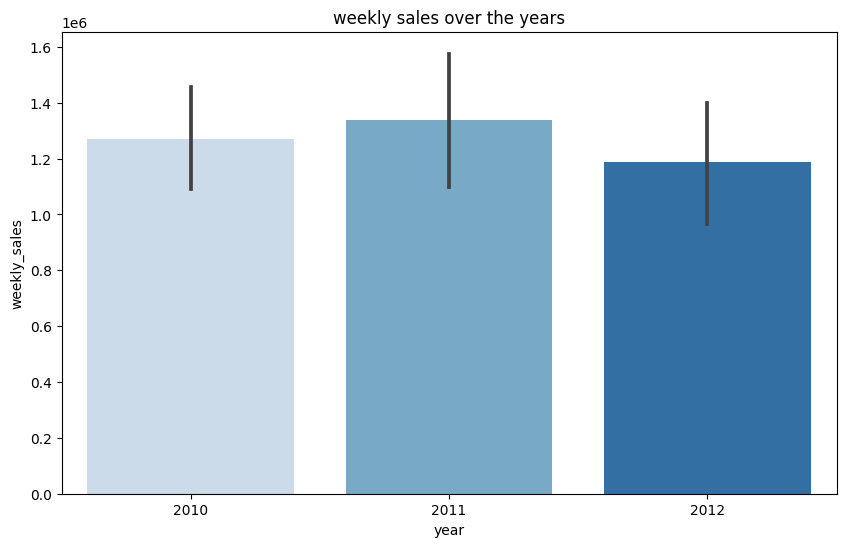

In [21]:
fig = plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='year', y='weekly_sales',palette= 'Blues').set_title('weekly sales over the years')
plt.show()

C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


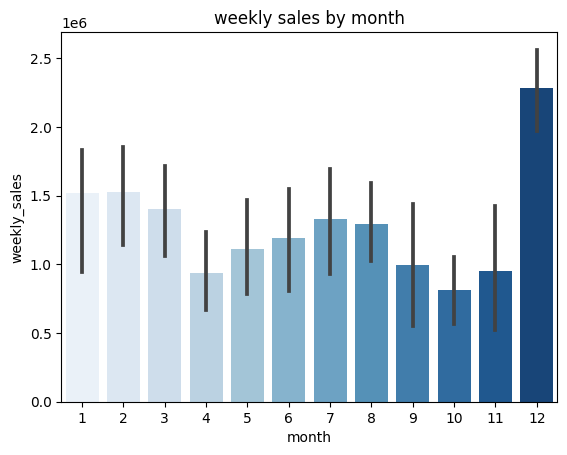

In [22]:
sns.barplot(data=df, x='month', y='weekly_sales',palette= 'Blues').set_title('weekly sales by month')
plt.show()

C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

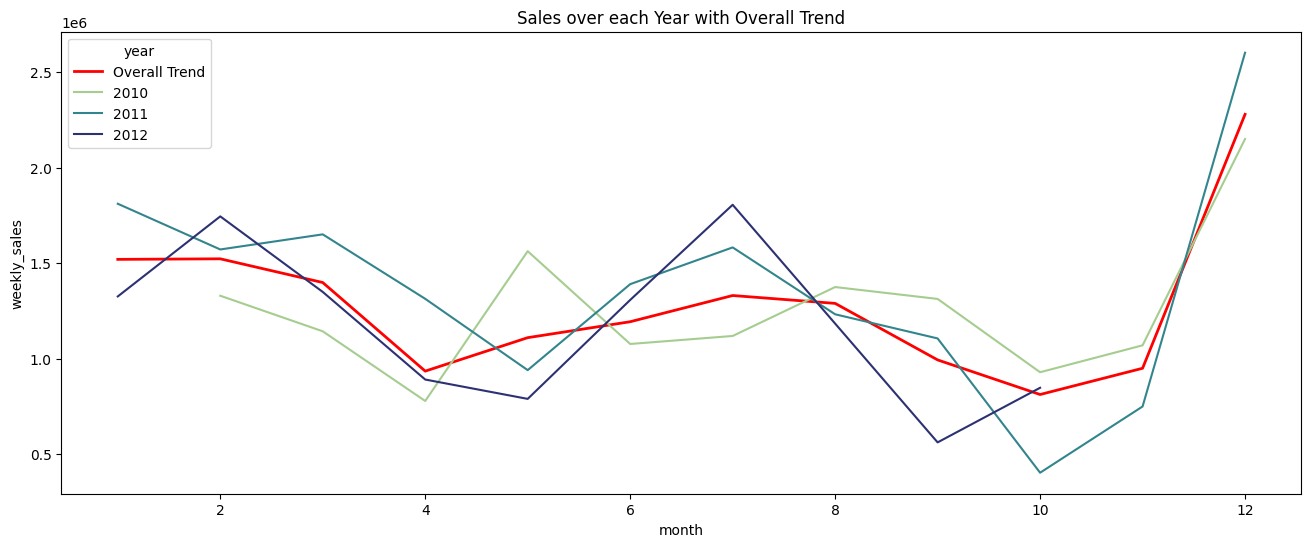

In [32]:

average_sales = df.groupby(['month'])['weekly_sales'].mean().reset_index()

# Graph Sales over each Year with Overall Trend
plt.figure(figsize=(16, 6))
#overall trend
sns.lineplot(x='month', y='weekly_sales', data=average_sales, label='Overall Trend', color='red', linewidth=2)
#differents years
sns.lineplot(x='month', y='weekly_sales', hue='year',palette='crest', data=df, errorbar=None)
plt.title('Sales over each Year with Overall Trend')
plt.show()

The sales in the year 2012 are at a lower level, except for the first few months of the year.

C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


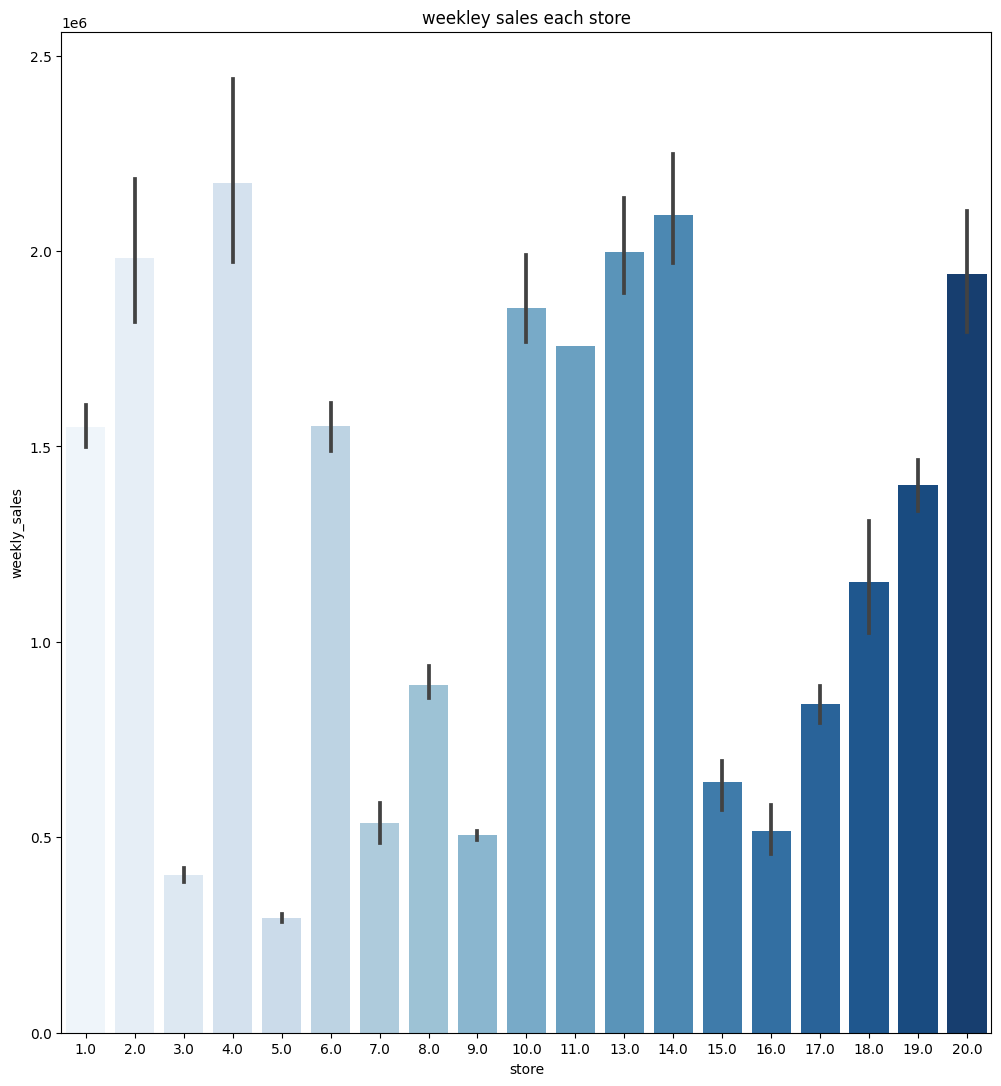

In [33]:
plt.figure(figsize=(12,13))
sns.barplot(x='store', y='weekly_sales',palette= 'Blues', data=df,).set_title('weekley sales each store')
plt.show()

- The stores with the highest sales are: 2, 4, 13, 14, and 20.
- The stores with the lowest sales are: 3, 4, 7, 9, 15, and 16.

C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Asus\AppData\Local\Temp\ipykernel_4616\3797988248.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df,
C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\User

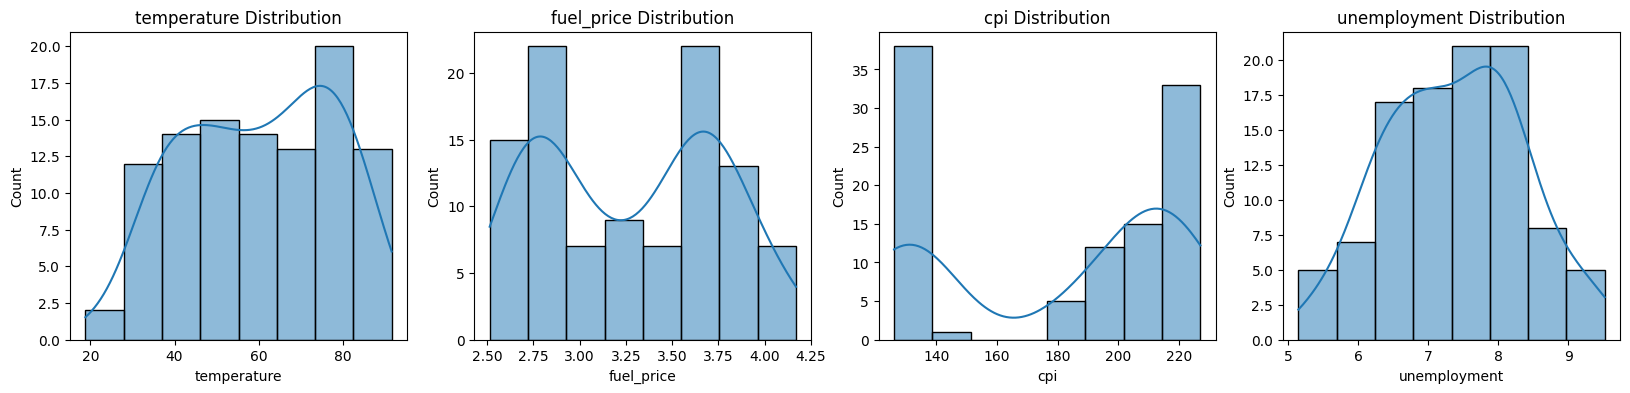

In [34]:
fig, ax = plt.subplots(1, 4, figsize=(20,4))
cols = ['temperature','fuel_price','cpi','unemployment']
for i,col in enumerate(cols):
    sns.histplot(df,
                 x=col,
                 ax=ax[i],
                 kde=True,
                 palette= 'Blues'
                )
    ax[i].set_title(f'{col} Distribution')
fig.show()


- Temperature Distribution (Graph 1):This pattern suggests a concentration of observations in the warmer temperature range, while lower temperatures have less presence in the dataset
- Fuel Price Distribution (Graph 2):In the fuel price histogram, the line exhibits two notable peaks, one around 2.75 and another around 3.75. These peaks indicate two particularly common fuel price ranges in the data.
- CPI (Consumer Price Index) Distribution (Graph 3):This pattern suggests a notable concentration of observations with a CPI around 130, followed by a decrease and subsequent increase in frequency for higher CPI values. The distribution in CPI may have implications for how consumer prices are distributed in the dataset.
-Unemployment Distribution (Graph 4):This pattern indicates an initial concentration of observations with low unemployment rates, followed by a progressive decrease towards higher unemployment rates.


C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


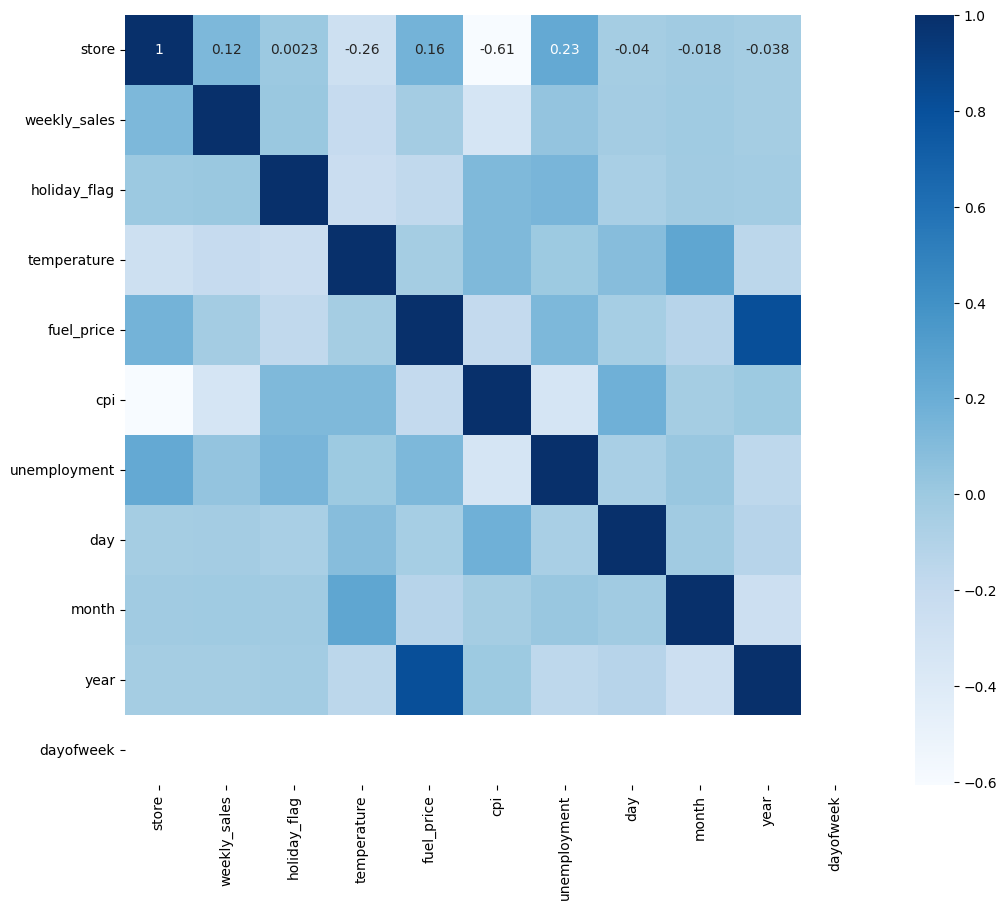

In [19]:
plt.figure(figsize=(12,10));
sns.heatmap(df.corr(numeric_only=True),cmap='Blues',annot=True);

- The correlation of 0.8 between 'fuel_price' and 'year' suggests a strong positive relationship over time. This finding may indicate an upward trend in fuel prices over the years, possibly influenced by factors such as changes in energy policies, global economic events, or technological advances in the fuel industry.
- The correlation of -0.6 between 'CPI' and 'store' indicates a moderately negative relationship. This association suggests that different stores may have distinct pricing strategies, influencing the variation in the Consumer Price Index (CPI)

In [36]:
def find_outliers(df, columns, k=1.5):
    # Dictionary to store outliers for each column
    outliers = {}

    # Iterate over specified columns
    for column in columns:
        # Calculate quartiles and IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define lower and upper limits for outliers
        lower_limit = Q1 - k * IQR
        upper_limit = Q3 + k * IQR

        # Store rows containing outliers in the dictionary
        outliers[column] = df[(df[column] < lower_limit) | (df[column] > upper_limit)]

    return outliers

# Find and store outliers for specified columns
outliers_data = find_outliers(df, columns=['temperature', 'fuel_price', 'cpi', 'unemployment'], k=1.5)

# Print the rows containing outliers for each column
for column, data in outliers_data.items():
    print(f"{len(data)} outliers found in column {column}")
    print(data)

# Remove rows containing outliers from the original DataFrame
for column, data in outliers_data.items():
    df = df[~df.index.isin(data.index)]

# Verify the new size of the DataFrame after removing outliers
print("New DataFrame size after removing outliers:", df.shape)


0 outliers found in column temperature
Empty DataFrame
Columns: [store, date, weekly_sales, holiday_flag, temperature, fuel_price, cpi, unemployment, day, month, year, dayofweek]
Index: []
0 outliers found in column fuel_price
Empty DataFrame
Columns: [store, date, weekly_sales, holiday_flag, temperature, fuel_price, cpi, unemployment, day, month, year, dayofweek]
Index: []
0 outliers found in column cpi
Empty DataFrame
Columns: [store, date, weekly_sales, holiday_flag, temperature, fuel_price, cpi, unemployment, day, month, year, dayofweek]
Index: []
0 outliers found in column unemployment
Empty DataFrame
Columns: [store, date, weekly_sales, holiday_flag, temperature, fuel_price, cpi, unemployment, day, month, year, dayofweek]
Index: []
New DataFrame size after removing outliers: (113, 12)


In [37]:
df.drop(columns=['date'], inplace=True)

- We removed null values in the 'weekly_sales' column, which is our target variable.
- Based on the days categorized as holidays, we filled in the information in the 'holiday_flag' column.
- We removed null values from the 'date' column.
- Outliers were removed.

# MODELS


In [38]:
y = df["weekly_sales"]
X = df.drop(columns=["weekly_sales"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [39]:
numeric_features = ['temperature', 'fuel_price','cpi', 'unemployment']
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler())
])


categorical_features = ['store','holiday_flag','month','day','dayofweek']
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first',handle_unknown='ignore'))
    ])

preprocessor = ColumnTransformer(
transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
    ])

In [40]:
X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)

## Linear Regression

In [41]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

lin_reg_metrics = {
    'Model': 'Linear Regression',
    'R2 Score (Train)': r2_score(y_train, y_train_pred),
    'R2 Score (Test)': r2_score(y_test, y_test_pred),
    'Cross-Val Std (Train)': cross_val_score(lin_reg, X_train, y_train, cv=10, scoring='r2').std()
}

print(lin_reg_metrics)


{'Model': 'Linear Regression', 'R2 Score (Train)': 0.9971643730620273, 'R2 Score (Test)': 0.9536860665445477, 'Cross-Val Std (Train)': 0.15562128867795705}


## Lasso

In [42]:
lasso_model = Lasso(max_iter=2000)
params      = {'alpha':[100,200,300,400,450,500]}

gridsearch_lasso = GridSearchCV(lasso_model, param_grid = params, cv = 15,scoring='r2')
gridsearch_lasso.fit(X_train, y_train)

best_alpha_lasso = gridsearch_lasso.best_params_['alpha']

lasso = Lasso(alpha=best_alpha_lasso)
lasso.fit(X_train, y_train)

y_train_pred_lasso = lasso.predict(X_train)
y_test_pred_lasso = lasso.predict(X_test)

lasso_metrics = {
    'Model': 'Lasso',
    'Best Alpha': best_alpha_lasso,
    'R2 Score (Train)': r2_score(y_train, y_train_pred_lasso),
    'R2 Score (Test)': r2_score(y_test, y_test_pred_lasso),
    'Cross-Val Std (Train)': cross_val_score(lasso, X_train, y_train, cv=10, scoring='r2').std()
}

print(lasso_metrics)

{'Model': 'Lasso', 'Best Alpha': 500, 'R2 Score (Train)': 0.9960679123458441, 'R2 Score (Test)': 0.9721053398294782, 'Cross-Val Std (Train)': 0.12586972326593385}


## Ridge

In [43]:
ridge_model = Ridge()
params = {'alpha': [0.01, 0.02, 0.03, 0.05]}
gridsearch_ridge = GridSearchCV(ridge_model, param_grid=params, cv=15, scoring='r2')
gridsearch_ridge.fit(X_train, y_train)

best_alpha_ridge = gridsearch_ridge.best_params_['alpha']

ridge = Ridge(alpha=best_alpha_ridge)
ridge.fit(X_train, y_train)

y_train_pred_ridge = ridge.predict(X_train)
y_test_pred_ridge = ridge.predict(X_test)

ridge_metrics = {
    'Model': 'Ridge',
    'Best Alpha': best_alpha_ridge,
    'R2 Score (Train)': r2_score(y_train, y_train_pred_ridge),
    'R2 Score (Test)': r2_score(y_test, y_test_pred_ridge),
    'Cross-Val Std (Train)': cross_val_score(ridge, X_train, y_train, cv=10, scoring='r2').std()
}

print(ridge_metrics)


{'Model': 'Ridge', 'Best Alpha': 0.05, 'R2 Score (Train)': 0.9962997202636056, 'R2 Score (Test)': 0.9673301793796056, 'Cross-Val Std (Train)': 0.14859715918153754}


Results

In [45]:
df_results = pd.DataFrame([lin_reg_metrics, lasso_metrics, ridge_metrics])
df_results

,Model,R2 Score (Train),R2 Score (Test),Cross-Val Std (Train),Best Alpha
0,Linear Regression,0.997164,0.953686,0.155621,NaN
1,Lasso,0.996068,0.972105,0.125870,500.00
2,Ridge,0.996300,0.967330,0.148597,0.05


The linear regression model has a high R2 Score in both the training and test sets, indicating a good fit. However, the difference in performance between the training and test sets suggests the presence of some degree of overfitting.

The Lasso model also exhibits a high R2 Score in both the training and test sets, indicating a good fit. The difference between the training and test scores is smaller than in the case of linear regression, suggesting a reduction in overfitting.

The Ridge model also shows good performance with high R2 Scores in both sets. The difference between the training and test scores is smaller than in linear regression but slightly larger than in the Lasso model.

Overall, the Lasso model appears to be the best among the three, as it has the highest R2 Score in the test set and a smaller difference between the training and test scores, suggesting less overfitting.